# Import Necessary Headers

In [1]:
import pandas as pd
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load Updated CSV into Pandas Dataframe¶

In [2]:
# Hong et al. Dataset
df = pd.read_csv("hong_et_al/df_updt.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560486 entries, 0 to 560485
Columns: 975 entries, dep_name to cc_wristpain
dtypes: float64(592), int64(368), object(15)
memory usage: 4.1+ GB


# Initial Preprocessing

In [3]:
# Drop columns containing traige information
triage_cols = [
    'dep_name', 'arrivalmode', 'arrivalmonth', 'arrivalday', 'arrivalhour_bin',
    'triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp', 'triage_vital_rr',
    'triage_vital_o2', 'triage_vital_o2_device', 'triage_vital_temp', 'esi'
]

df = df.drop(columns=triage_cols)
df = df.drop(columns=df.filter(like='(pcp)screen').columns)

# Drop chief complaint columns (collected at hospital check in)
df = df.drop(columns=df.filter(regex='^cc_').columns)

# Filter out demographic specific eGFR data
df = df.drop(columns=df.filter(regex='^egfr\(').columns)

# Drop rows with nan entries for Y value
df = df.dropna(subset=['stg_proximity_ratio'])

# Impute median data for any remaining NaN values in numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df.replace([np.inf, -np.inf], np.nan, inplace=True) # Ensure no infinite values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Impute mode data for any remaining NaN values in categorical columns
categorical_cols = ['gender', 'ethnicity', 'race', 'lang', 'religion', 'maritalstatus',
                    'employstatus', 'insurance_status', 'disposition', 'previousdispo']

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212891 entries, 6 to 560485
Columns: 805 entries, age to previousdispo_Transfer to Another Facility
dtypes: bool(65), float64(372), int64(368)
memory usage: 1.2 GB


In [5]:
non_numeric_columns = df.select_dtypes(include=['object', 'category']).columns

print(non_numeric_columns)

Index([], dtype='object')


# Define Train and Test Data Splits

In [6]:
# Exclude target variable from features frame
X = df.drop(columns=df.filter(like='stg_proximity_ratio').columns)
y = df['stg_proximity_ratio']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Ensure no NaN values in tensors
assert not X_train_tensor.isnan().any(), "NaN values found in X_train_tensor"
assert not y_train_tensor.isnan().any(), "NaN values found in y_train_tensor"

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define ResNet NN

In [7]:
# Define single residual block for tabular data
class ResNetBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        residual = x # Save the input for the residual connection
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = out + residual # Add the residual (input) to the output
        out = self.relu(out)
        return out

# Define ResNet model for tabular data
class ResNetForTabular(nn.Module):
    def __init__(self, input_dim, num_blocks, hidden_dim):
        super(ResNetForTabular, self).__init__()
        self.initial_fc = nn.Linear(input_dim, hidden_dim) # Initial fully connected layer
        self.res_blocks = nn.Sequential(
            *[ResNetBlock(hidden_dim, hidden_dim) for _ in range(num_blocks)] # Stack multiple residual blocks
        )
        self.final_fc = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.initial_fc(x)
        out = self.relu(out)
        out = self.res_blocks(out)
        out = self.final_fc(out)
        return out

# Hyperparameters
input_dim = X_train.shape[1]
num_blocks = 3
hidden_dim = 64


# Initialize the model
model = ResNetForTabular(input_dim, num_blocks, hidden_dim)

# Load model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNetForTabular(
  (initial_fc): Linear(in_features=804, out_features=64, bias=True)
  (res_blocks): Sequential(
    (0): ResNetBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
    (1): ResNetBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): ResNetBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (final_fc): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

# Training Loop

In [8]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 30
best_val_loss = float('inf')
early_stop_count = 0
patience = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered")
        break

# Save the trained model
torch.save(model.state_dict(), 'model.pth')

Epoch 1/30, Training Loss: 0.015029146538630678, Validation Loss: 0.005398621938754902
Epoch 2/30, Training Loss: 0.003873284928168112, Validation Loss: 0.0026927462856071323
Epoch 3/30, Training Loss: 0.002498235045060649, Validation Loss: 0.0016718522313242505
Epoch 4/30, Training Loss: 0.0018968046326874207, Validation Loss: 0.0014172373839455457
Epoch 5/30, Training Loss: 0.001619961881966545, Validation Loss: 0.0020940478318846327
Epoch 6/30, Training Loss: 0.001448380584175589, Validation Loss: 0.0015619894191266147
Epoch 7/30, Training Loss: 0.0012826193531312693, Validation Loss: 0.0015680771793449275
Early stopping triggered


# Evaluate Accuracy on Test Set

In [9]:
# Switch the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true values
all_predictions = []
all_labels = []

# Predict and evaluate
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches into a single array
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

# Calculate metrics
mse = mean_squared_error(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.001569398446008563
Mean Absolute Error: 0.025798283517360687


# SHAP Explainer

In [10]:
# Select a subset of the training data to use as the background dataset for SHAP
background = X_train_tensor[:100].to(device)

# Initialize the SHAP DeepExplainer with the model and background dataset
explainer = shap.DeepExplainer(model, background)

# Define the list to store SHAP values
shap_list = []

# Set the batch size for SHAP computation
batch_size = 256

# Convert the tensor to numpy for slicing
X_test_np = X_test_tensor.cpu().numpy()

# Create indices for batching, ensuring all samples are covered
num_batches = int(np.ceil(X_test_np.shape[0] / batch_size))
idxs = np.array_split(np.arange(X_test_np.shape[0]), num_batches)

# Use tqdm to display a progress bar for SHAP value computation
for idx in tqdm(idxs, total=len(idxs)):
    # Compute SHAP values for the current batch
    shaps = explainer.shap_values(torch.from_numpy(X_test_np[idx]).to(device), check_additivity=False)
    
    # If the model has a single output, shaps will be a single array
    if isinstance(shaps, list):
        shap_list.append(shaps[0])
    else:
        shap_list.append(shaps)

# Concatenate the list of SHAP values into a single array
shap_values = np.concatenate(shap_list, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [05:25<00:00,  1.95s/it]


In [11]:
# Ensure shap_values has the correct shape
if len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 0]

# Print shapes after squeezing
print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_test_np: {X_test_np.shape}")

Shape of shap_values: (42579, 804)
Shape of X_test_np: (42579, 804)


# SHAP Summary Plot

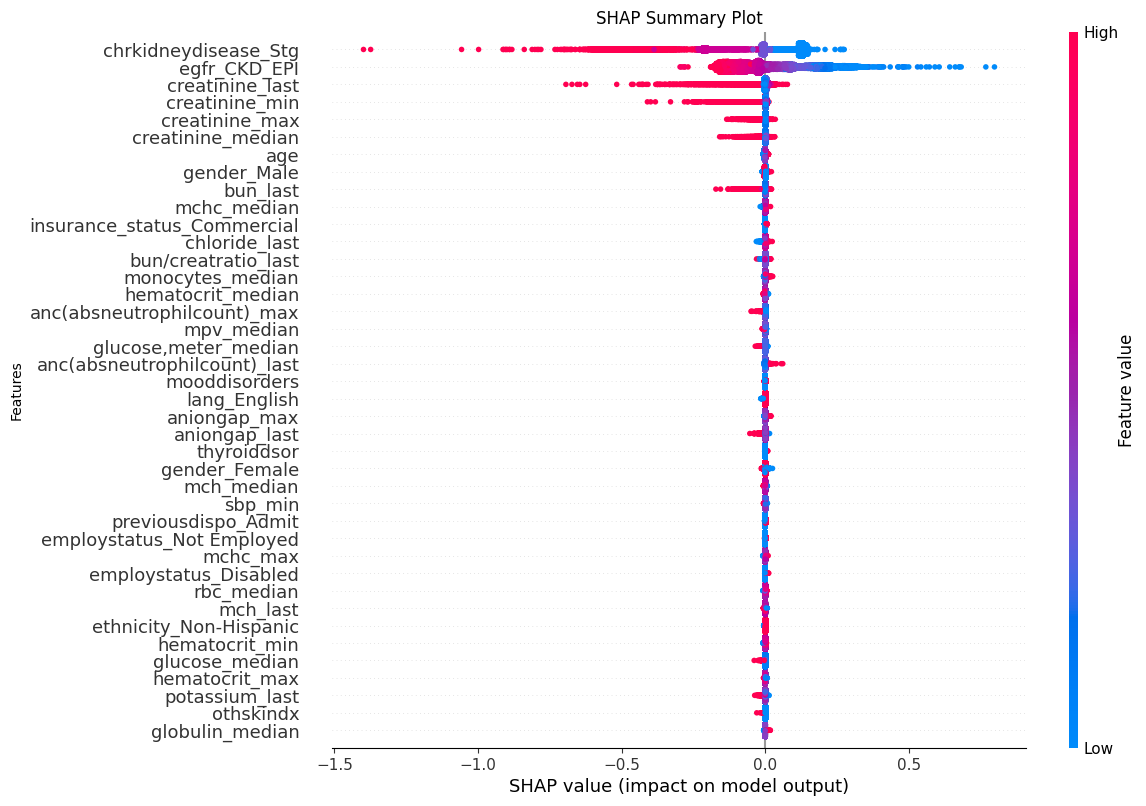

In [12]:
# Set a larger plot size for better readability
plt.figure(figsize=(12, 8))

# Create the summary plot with additional customizations
shap.summary_plot(
    shap_values, 
    X_test_np, 
    feature_names=X.columns.tolist(), 
    plot_size=(12, 8), 
    max_display=40,  # Limit to top 40 features
    show=False  # Disable immediate display to customize further
)

# Customize plot appearance
plt.title('SHAP Summary Plot')
plt.xlabel('SHAP value (impact on model output)')
plt.ylabel('Features')

# Show the plot
plt.show()